**Inception V3 Model**

In [44]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import Inception_V3_Weights
from PIL import Image
import matplotlib.pyplot as plt

In [45]:
class RockPaperScissorsDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = {'rock': 0, 'paper': 1, 'scissors': 2}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        image = Image.open(img_path).convert("RGB")
        label = self.class_to_idx[row['class'].lower()]
        if self.transform:
            image = self.transform(image)
        return image, label

In [46]:
# --- Transforms ---

train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

In [47]:
train_dataset = RockPaperScissorsDataset(train_df, train_img_dir, transform=train_transform)
val_dataset = RockPaperScissorsDataset(val_df, train_img_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


In [48]:
# --- Load pretrained InceptionV3 model ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = Inception_V3_Weights.DEFAULT
model = models.inception_v3(weights=weights, aux_logits=True)

# Freeze all params
for param in model.parameters():
    param.requires_grad = False

# Replace final fully connected layer with 3-class output
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)

# Also replace auxiliary classifier's fc layer for 3 classes
num_aux_features = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_aux_features, 3)

# Unfreeze final layers
for param in model.fc.parameters():
    param.requires_grad = True
for param in model.AuxLogits.fc.parameters():
    param.requires_grad = True

model = model.to(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/cconcha/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|████████████████████████████████████████████████████████████████████████████████| 104M/104M [00:05<00:00, 19.2MB/s]


In [49]:
# --- Loss and optimizer ---

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(model.fc.parameters()) + list(model.AuxLogits.fc.parameters()), lr=0.001)

In [50]:
# --- Training parameters ---

num_epochs = 20
train_losses = []
val_accuracies = []

In [51]:
# --- Training and validation loop ---

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs, aux_outputs = model(inputs)

        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2  # Weighted auxiliary loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # During eval, returns only outputs

            # outputs is a single tensor during evaluation when aux_logits=True
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total

    train_losses.append(epoch_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Val Accuracy: {val_acc:.4f}")

print("Training complete.")


Epoch 1/20 - Train Loss: 1.6865 - Val Accuracy: 0.3333
Epoch 2/20 - Train Loss: 1.5195 - Val Accuracy: 0.3333
Epoch 3/20 - Train Loss: 1.4363 - Val Accuracy: 0.3667
Epoch 4/20 - Train Loss: 1.3478 - Val Accuracy: 0.4167
Epoch 5/20 - Train Loss: 1.3494 - Val Accuracy: 0.4500
Epoch 6/20 - Train Loss: 1.2939 - Val Accuracy: 0.4667
Epoch 7/20 - Train Loss: 1.2265 - Val Accuracy: 0.4500
Epoch 8/20 - Train Loss: 1.1492 - Val Accuracy: 0.4833
Epoch 9/20 - Train Loss: 1.1075 - Val Accuracy: 0.5167
Epoch 10/20 - Train Loss: 1.0584 - Val Accuracy: 0.4833
Epoch 11/20 - Train Loss: 1.0605 - Val Accuracy: 0.4667
Epoch 12/20 - Train Loss: 1.0151 - Val Accuracy: 0.5000
Epoch 13/20 - Train Loss: 0.9857 - Val Accuracy: 0.4667
Epoch 14/20 - Train Loss: 0.9485 - Val Accuracy: 0.4667
Epoch 15/20 - Train Loss: 0.9285 - Val Accuracy: 0.5000
Epoch 16/20 - Train Loss: 0.9543 - Val Accuracy: 0.4667
Epoch 17/20 - Train Loss: 0.9053 - Val Accuracy: 0.5167
Epoch 18/20 - Train Loss: 0.8992 - Val Accuracy: 0.5000
E

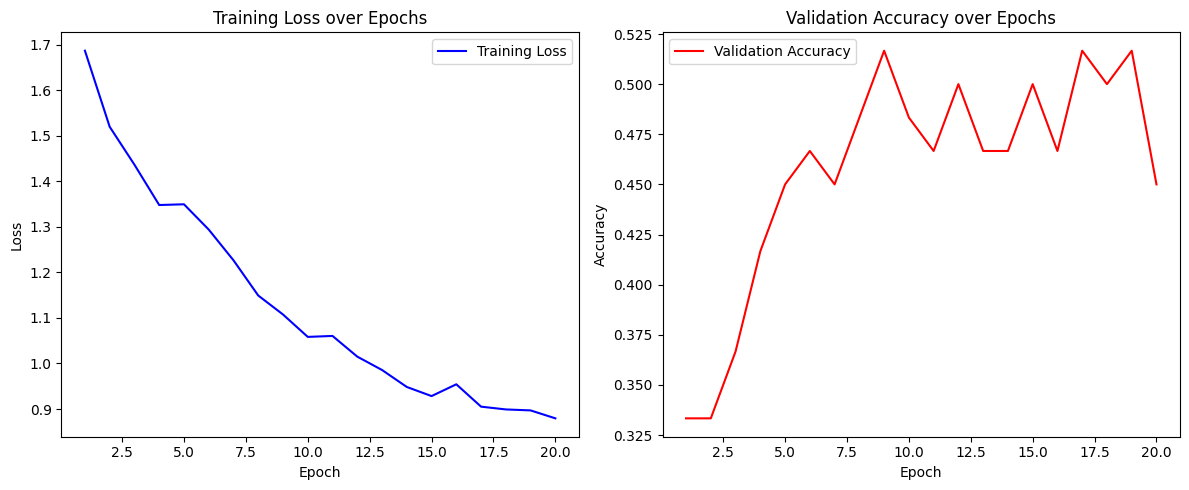

In [52]:
# --- Plot learning curves ---

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()